## Environment Setup and Imports

### Library imports

In [0]:
import pandas as pd
import csv
import pickle
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D, MaxPool1D, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import h5py
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import backend as K

import tensorflow as tf
from tensorflow.python.client import device_lib

from adabound import AdaBound

In [0]:
import nltk
nltk.download("all")

### Setup for display window

In [0]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', 1000)

### Setting up the GPU device ( if available )

In [0]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print(device_lib.list_local_devices())

In [3]:
K.tensorflow_backend._get_available_gpus()

W0821 03:22:51.283357 140388142139264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0821 03:22:51.285747 140388142139264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0821 03:22:51.286915 140388142139264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0821 03:22:52.570583 140388142139264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

### Downloading glove vector

In [4]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip glove*.zip
!ls

--2019-08-21 03:22:53--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2019-08-21 03:22:54--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2019-08-21 03:22:54--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

#### Load Glove vector in pandas dataframe

In [5]:
glove = pd.read_table("glove.42B.300d.txt", sep=' ', index_col=0, header=None, quoting=csv.QUOTE_NONE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [6]:
glove.head()

1         2         3    ...       298       299       300
0                                 ...                              
,    0.18378 -0.121230 -0.119870  ... -0.039038  0.182740  0.146540
the -0.20838 -0.149320 -0.017528  ... -0.540660  0.211990 -0.009436
.    0.10876  0.002244  0.222130  ... -0.296960  0.159390 -0.149020
and -0.09611 -0.257880 -0.358600  ... -0.370300 -0.092774  0.390580
to  -0.24837 -0.454610  0.039227  ...  0.053097  0.154580 -0.380530

[5 rows x 300 columns]

In [7]:
glove.shape

(1917494, 300)

### Loading Data

In [8]:
critical_df = pd.read_csv("critical-findings-sample-data-20180601-20180901.csv")
critical_df.head()

Modality  ...                                               Data
0       CT  ...  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
1       CT  ...  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
2       CT  ...  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
3       CT  ...  HISTORY: left sided weakness<br /><br />TECHNI...
4       CT  ...  HISTORY: left sided weakness<br /><br />TECHNI...

[5 rows x 4 columns]

In [9]:
non_critical_df = pd.read_csv("non-critical-findings-sample-data-20180601-20180901.csv")
non_critical_df.head()

Modality  ...                                               Data
0       CR  ...  STUDY:   X-RAY - LEFT HAND<br /><br />REASON F...
1       US  ...  STUDY:   VENOUS DOPPLER ULTRASOUND -LEFT UPPER...
2       CR  ...  XR Chest 1 View<br /><br />INDICATION: for com...
3       CR  ...  STUDY:   X-RAY CHEST<br /><br />REASON FOR EXA...
4       US  ...  STUDY:   VENOUS DOPPLER ULTRASOUND - LEFT LOWE...

[5 rows x 4 columns]

### Combining critical and non-critical data

In [10]:
critical_and_non_critical_df = pd.concat([critical_df, non_critical_df], axis=0).reset_index(drop=True)
critical_and_non_critical_df.head()

Modality  ...                                               Data
0       CT  ...  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
1       CT  ...  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
2       CT  ...  STUDY:   CT CHEST WITH CONTRAST<br /><br />REA...
3       CT  ...  HISTORY: left sided weakness<br /><br />TECHNI...
4       CT  ...  HISTORY: left sided weakness<br /><br />TECHNI...

[5 rows x 4 columns]

## Data Cleaning

### Removing tags

In [11]:
critical_and_non_critical_df.Data = critical_and_non_critical_df.Data.str.replace("<br />", " ").str.lower()
critical_and_non_critical_df.head()

Modality  ...                                               Data
0       CT  ...  study:   ct chest with contrast  reason for ex...
1       CT  ...  study:   ct chest with contrast  reason for ex...
2       CT  ...  study:   ct chest with contrast  reason for ex...
3       CT  ...  history: left sided weakness  technique: ct he...
4       CT  ...  history: left sided weakness  technique: ct he...

[5 rows x 4 columns]

### Removing punctuations

In [0]:
def remove_punctuation(text):
    
    translator = str.maketrans('', '', string.punctuation + "0123456789")
    
    return text.translate(translator)

In [13]:
critical_and_non_critical_df.Data = critical_and_non_critical_df.Data.apply(remove_punctuation)
critical_and_non_critical_df.head()

Modality  ...                                               Data
0       CT  ...  study   ct chest with contrast  reason for exa...
1       CT  ...  study   ct chest with contrast  reason for exa...
2       CT  ...  study   ct chest with contrast  reason for exa...
3       CT  ...  history left sided weakness  technique ct head...
4       CT  ...  history left sided weakness  technique ct head...

[5 rows x 4 columns]

### Removing Stopwords

In [0]:
def stop_words(text) :
    
    text = [word for word in text.split() if word not in stopwords.words("english")]
    
    return " ".join(text)

In [0]:
# critical_and_non_critical_df.Data = critical_and_non_critical_df.Data.apply(stop_words)
# critical_and_non_critical_df.head()

### Lemmatizing the data

Changing words to their root lemma

In [0]:
lemmatizer = WordNetLemmatizer()

def lemmatizing(text):    
    
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text)

In [18]:
critical_and_non_critical_df.Data = critical_and_non_critical_df.Data.apply(lemmatizing)
critical_and_non_critical_df.head()

Modality  ...                                               Data
0       CT  ...  study ct chest with contrast reason for exam m...
1       CT  ...  study ct chest with contrast reason for exam m...
2       CT  ...  study ct chest with contrast reason for exam m...
3       CT  ...  history left sided weakness technique ct head ...
4       CT  ...  history left sided weakness technique ct head ...

[5 rows x 4 columns]

### Removing shorter words

In [0]:
def remove_single_length_words(text) :
    
    text = [word for word in word_tokenize(text) if len(word) > 1]
    
    return " ".join(text)

In [20]:
critical_and_non_critical_df.Data = critical_and_non_critical_df.Data.apply(remove_single_length_words)
critical_and_non_critical_df.head()

Modality  ...                                               Data
0       CT  ...  study ct chest with contrast reason for exam m...
1       CT  ...  study ct chest with contrast reason for exam m...
2       CT  ...  study ct chest with contrast reason for exam m...
3       CT  ...  history left sided weakness technique ct head ...
4       CT  ...  history left sided weakness technique ct head ...

[5 rows x 4 columns]

### Getting numeric lablels for target variable

In [21]:
critical_and_non_critical_df.Critical_Finding.replace(["None", "Complete Critical Finding", "Complete Physician Decline"], [0, 1, 1], inplace=True)
critical_and_non_critical_df.head(15)

Modality  ...                                               Data
0          CT  ...  study ct chest with contrast reason for exam m...
1          CT  ...  study ct chest with contrast reason for exam m...
2          CT  ...  study ct chest with contrast reason for exam m...
3          CT  ...  history left sided weakness technique ct head ...
4          CT  ...  history left sided weakness technique ct head ...
5          CT  ...  study ct abdomen and pelvis without contrast r...
6          CT  ...  study ct abdomen and pelvis without contrast r...
7          CT  ...  study ct abdomen and pelvis without contrast r...
8          CR  ...  study xray chest reason for exam male year old...
9          CR  ...  study xray chest reason for exam male year old...
10         CR  ...  study xray chest reason for exam male year old...
11  RG,CT,CTA  ...  study cta chest reason for exam male year old ...
12  RG,CT,CTA  ...  study cta chest reason for exam male year old ...
13  RG,CT,CTA  ...  study cta chest reason for exam male year old ...
14         CT  ...  study ct abdomen and pelvis with contrast reas...

[15 rows x 4 columns]

### Sampling the data

To get good distribution of data for training and testing

In [28]:
critical_and_non_critical_df = critical_and_non_critical_df.sample(frac=1).reset_index(drop=True)
critical_and_non_critical_df.head(15)

Modality  ...                                               Data
0        CR  ...  study xray chest reason for exam male year old...
1        CT  ...  ct abdomen and pelvis contrast indication abd ...
2        CT  ...  study ct abdomen and pelvis without contrast r...
3        CT  ...  study ct brain without contrast reason for exa...
4        MR  ...  study mri brain without contrast reason for ex...
5        CT  ...  study ct brain without contrast reason for exa...
6        CR  ...  study xray orbit reason for exam female year o...
7        MR  ...  study mri lumbar spine without contrast reason...
8        CR  ...  study xray chest reason for exam female year o...
9        CT  ...  study ct brain without contrast reason for exa...
10       CT  ...  finding discussed with dr morrison previous re...
11   CT,CTA  ...  study cta chest reason for exam female year ol...
12       CR  ...  study xray left tibia and fibula reason for ex...
13       US  ...  study venous doppler ultrasound left lower ext...
14       CT  ...  study ct brain without contrast reason for exa...

[15 rows x 4 columns]

### Maintaining unique word count

In [0]:
words_count = {}

def count_words(text) :
    
    for word in word_tokenize(text) :
        if word not in words_count.keys() :
            words_count[word] = 1
        else :
            words_count[word] += 1


In [24]:
critical_and_non_critical_df.Data.apply(count_words)
sorted(words_count.items(), reverse=True, key=lambda kv : (kv[1], kv[0]))

[('the', 8798),
 ('normal', 5774),
 ('of', 5500),
 ('is', 4497),
 ('and', 4446),
 ('there', 3754),
 ('no', 2339),
 ('are', 1892),
 ('right', 1800),
 ('with', 1777),
 ('for', 1742),
 ('visualized', 1716),
 ('left', 1623),
 ('in', 1499),
 ('technique', 1443),
 ('ct', 1359),
 ('finding', 1231),
 ('contrast', 1209),
 ('to', 1090),
 ('were', 1032),
 ('impression', 973),
 ('image', 952),
 ('comparison', 938),
 ('study', 924),
 ('without', 894),
 ('or', 884),
 ('chest', 829),
 ('exam', 824),
 ('old', 822),
 ('cm', 793),
 ('artery', 783),
 ('reason', 777),
 ('bilateral', 763),
 ('year', 752),
 ('this', 741),
 ('by', 741),
 ('pulmonary', 647),
 ('at', 641),
 ('mild', 629),
 ('small', 616),
 ('wa', 603),
 ('acute', 598),
 ('none', 593),
 ('within', 583),
 ('lung', 574),
 ('tissue', 557),
 ('soft', 552),
 ('structure', 551),
 ('dose', 548),
 ('optimization', 547),
 ('used', 540),
 ('change', 540),
 ('abdomen', 538),
 ('demonstrated', 514),
 ('individualized', 486),
 ('upper', 479),
 ('on', 476),


## Feature Extraction using Glove

### Getting word embeddings from glove

In [0]:
word_embeddings = {}
non_glove_words = {}
# embedding_matrix = np.zeros( (len(words_count) + 1, 300) )
for i, word in enumerate(words_count.keys()) :
    if word in glove.index :
        word_embeddings[word] = glove.loc[ word, : ].values
#         embedding_matrix[i] = word_embeddings[word]
    else :
        non_glove_words[word] = words_count[word]

In [26]:
word_embeddings

{'study': array([-1.7148e-02, -1.6388e-02,  3.4868e-02,  3.2143e-01, -7.5327e-01,
         4.0726e-01, -2.9914e+00,  7.9809e-01, -4.8536e-01,  9.5204e-01,
         2.6715e-01, -9.7982e-02, -2.2655e-01, -1.8363e-02, -2.8916e-01,
         4.7495e-02,  3.8304e-01,  1.5354e-01,  2.9469e-01,  3.6776e-01,
        -3.7541e-01,  1.3299e-01, -5.7010e-02,  3.9326e-02, -4.2973e-01,
        -2.2337e-01,  1.3391e-01,  2.1624e-01, -2.3586e-01, -7.7153e-02,
         5.2858e-02, -1.9859e-01, -2.0735e-01,  7.0480e-02,  2.6219e-01,
         2.0460e-01,  1.7730e-01,  2.0221e-01, -1.0936e-01, -2.6740e-01,
        -2.1244e-01, -6.3181e-01, -1.9556e-01, -1.7793e-01,  2.3319e-01,
        -7.4931e-01,  4.5611e-02,  1.6643e-01,  2.3702e-01,  2.2617e-01,
        -1.5093e-01,  1.2791e-01,  4.3531e-01, -2.7760e-01, -7.4655e-03,
         3.3494e-01,  4.9226e-01,  3.4251e-01, -7.7871e-01, -2.9034e-01,
        -5.9305e-01, -2.0137e-02, -8.3040e-02,  2.4837e-01, -3.8617e-01,
         9.8694e-01, -3.9236e-02, -3.2062e

### Non-glove words

In [27]:
sorted(non_glove_words.items(), reverse=True, key=lambda kv : (kv[1], kv[0]))

[('mgycm', 315),
 ('ctdivol', 299),
 ('extraaxial', 158),
 ('leftsided', 85),
 ('weismcnulty', 84),
 ('kamholtz', 50),
 ('barchie', 50),
 ('neuroforamina', 47),
 ('breckwoldt', 44),
 ('nonvisualization', 32),
 ('airfluid', 27),
 ('nondistended', 26),
 ('nonobstructing', 25),
 ('lowattenuation', 25),
 ('periappendiceal', 24),
 ('cmsec', 24),
 ('hyperdensity', 22),
 ('fluidfilled', 21),
 ('costophrenic', 20),
 ('uncovertebral', 19),
 ('pericholecystic', 19),
 ('paintech', 19),
 ('bibasilar', 19),
 ('mildmoderate', 18),
 ('hydroureter', 18),
 ('paraspinous', 17),
 ('illdefined', 17),
 ('appendicolith', 17),
 ('graywhite', 16),
 ('paracolic', 15),
 ('intraaxial', 15),
 ('hypoattenuation', 15),
 ('fatcontaining', 14),
 ('examtechnique', 14),
 ('ageappropriate', 14),
 ('thickwalled', 13),
 ('subcentimeter', 13),
 ('pleuralbased', 13),
 ('dextroscoliosis', 13),
 ('atelectatic', 13),
 ('abdomenpelvis', 13),
 ('veingreater', 12),
 ('perihepatic', 12),
 ('pericolonic', 12),
 ('neuroforaminal', 1

### Generating text vectors for each row

In [0]:
sent_vectors = []

def vectorize_sentence(text) :
    
    sen_vec = np.zeros(300)
    for word in text.split() :
        if word in word_embeddings.keys() :
            sen_vec += word_embeddings[word]
    
    sent_vectors.append(sen_vec)

In [31]:
critical_and_non_critical_df.Data.apply(vectorize_sentence)
print()

In [32]:
np.array(sent_vectors).shape

(1000, 300)

In [0]:
sent_embedding_matrix = np.array(sent_vectors)

### Scaling the data

In [0]:
scaler = StandardScaler()

combined_tfidf_embed_scaled = scaler.fit_transform(sent_embedding_matrix)

## Modeling (with glove only)

### Logistic Regression

In [115]:
xtrain_embed, xvalid_embed, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

lreg_embed = LogisticRegression()
lreg_embed.fit(xtrain_embed, ytrain) # training the model

prediction = lreg_embed.predict_proba(xvalid_embed) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9133333333333333

### RandomForest Classifier

In [116]:
xtrain_embed, xvalid_embed, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

rfr_embed = RandomForestClassifier()
rfr_embed.fit(xtrain_embed, ytrain) # training the model

prediction = rfr_embed.predict_proba(xvalid_embed) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.88

### SVC

In [124]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

svc_tfidf = SVC(C=1.0, kernel='linear', degree=3, probability=True)
svc_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = svc_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.9366666666666666

### MLP Classifier

In [119]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

mlp_clf_tfidf = MLPClassifier([1000, 500, 100], learning_rate_init=0.01, learning_rate='adaptive')
mlp_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = mlp_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.92

### AdaBoost Classifier

In [120]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

ada_boost_tfidf = AdaBoostClassifier(n_estimators=3000, learning_rate=0.1)
ada_boost_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = ada_boost_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.9133333333333333

### Bagging Classifier

In [126]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

bag_clf_tfidf = BaggingClassifier(n_estimators=3000, n_jobs=-1)
bag_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = bag_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.945

### ExtraTrees Classifier

In [127]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

extra_trees_clf_tfidf = ExtraTreesClassifier(n_estimators=3000, n_jobs=-1, )
extra_trees_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = extra_trees_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.94

### GradientBoosting Classifier

In [38]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

grd_boost_clf_tfidf = GradientBoostingClassifier(n_estimators=3000)
grd_boost_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = grd_boost_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.92

### Keras DenseNet model

#### Creating the model

In [0]:
def create_baseline():
    
    model = Sequential()
    model.add(Dense(100, input_dim=combined_tfidf_embed_scaled.shape[1], activation='relu'))
    model.add(Dropout(0.5))
#     model.add(Dense(8192, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(2048, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    optm = AdaBound(lr=1e-03,
                final_lr=0.1,
                gamma=1e-03,
                weight_decay=0.,
                amsbound=False)
    
    model.compile(loss='binary_crossentropy', optimizer=optm, metrics=['accuracy'])
    return model

#### Training the model

In [113]:
X_train, X_test, y_train, y_test = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, test_size=0.1, random_state=42)

estimator = KerasClassifier(build_fn=create_baseline, epochs=300, batch_size=200, verbose=1)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
early_stopping_monitor = EarlyStopping(patience=3)
history = estimator.fit(X_train, y_train, validation_split=0.10)

Train on 810 samples, validate on 90 samples
Epoch 1/300
810/810 [==============================] - 1s 2ms/step - loss: 0.8821 - acc: 0.5099 - val_loss: 0.6220 - val_acc: 0.7111
Epoch 2/300
810/810 [==============================] - 0s 39us/step - loss: 0.7939 - acc: 0.6111 - val_loss: 0.5775 - val_acc: 0.7444
Epoch 3/300
810/810 [==============================] - 0s 38us/step - loss: 0.6653 - acc: 0.6531 - val_loss: 0.5630 - val_acc: 0.7444
Epoch 4/300
810/810 [==============================] - 0s 39us/step - loss: 0.6929 - acc: 0.6543 - val_loss: 0.5448 - val_acc: 0.7444
Epoch 5/300
810/810 [==============================] - 0s 40us/step - loss: 0.6625 - acc: 0.6914 - val_loss: 0.5266 - val_acc: 0.7778
Epoch 6/300
810/810 [==============================] - 0s 39us/step - loss: 0.6308 - acc: 0.6802 - val_loss: 0.5240 - val_acc: 0.7556
Epoch 7/300
810/810 [==============================] - 0s 41us/step - loss: 0.6317 - acc: 0.7049 - val_loss: 0.5148 - val_acc: 0.7778
Epoch 8/300
810/81

#### Evaluating the model

In [114]:
estimator.score(X_test, y_test)

100/100 [==============================] - 0s 38us/step


0.9300000071525574

#### Plotting the accuracy and loss graph

In [0]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

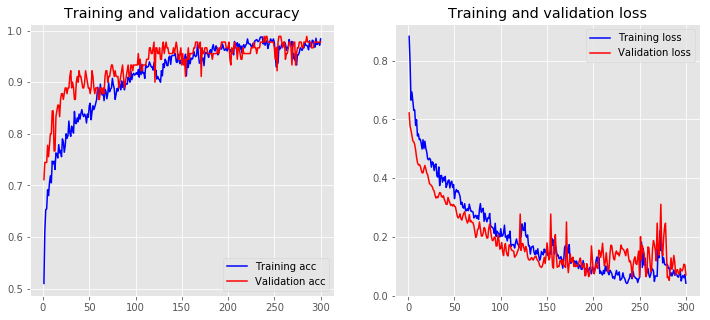

In [116]:
plot_history(history)

## Feature Extraction (using Glove + Tfidf)

### Tf-Idf Features

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, ngram_range=(1, 2), stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(critical_and_non_critical_df.Data)
tfidf_array = tfidf_matrix.todense()
tfidf_array.shape

(1000, 21888)

### Combine tfidf and glove embeddings

In [0]:
combined_tfidf_embed = np.concatenate( (tfidf_array, sent_embedding_matrix), axis=1 )
combined_tfidf_embed.shape

(1000, 22188)

### Scaling the data

In [0]:
scaler = StandardScaler()

combined_tfidf_embed_scaled = scaler.fit_transform(combined_tfidf_embed)

## Modeling (with tfidf + glove)

### Logistic Regression

In [37]:
xtrain_embed, xvalid_embed, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

lreg_embed = LogisticRegression()
lreg_embed.fit(xtrain_embed, ytrain) # training the model

prediction = lreg_embed.predict_proba(xvalid_embed) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9666666666666667

### RandomForest Classifier

In [38]:
xtrain_embed, xvalid_embed, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

rfr_embed = RandomForestClassifier()
rfr_embed.fit(xtrain_embed, ytrain) # training the model

prediction = rfr_embed.predict_proba(xvalid_embed) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.885

### SVC

In [40]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

svc_tfidf = SVC(C=1.0, kernel='linear', degree=3, probability=True)
svc_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = svc_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.9866666666666667

### MLP Classifier

In [41]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

mlp_clf_tfidf = MLPClassifier([1000, 500, 100], learning_rate_init=0.01, learning_rate='adaptive')
mlp_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = mlp_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.95

### AdaBoost Classifier

In [0]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

ada_boost_tfidf = AdaBoostClassifier(n_estimators=3000, learning_rate=0.1)
ada_boost_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = ada_boost_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

### Bagging Classifier

In [44]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

bag_clf_tfidf = BaggingClassifier(n_estimators=3000, n_jobs=-1)
bag_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = bag_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.915

### ExtraTrees Classifier

In [45]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

extra_trees_clf_tfidf = ExtraTreesClassifier(n_estimators=3000, n_jobs=-1, )
extra_trees_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = extra_trees_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.94

### GradientBoosting Classifier

In [46]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

grd_boost_clf_tfidf = GradientBoostingClassifier(n_estimators=3000)
grd_boost_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = grd_boost_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.9366666666666666

### Keras DenseNet Model

#### Creating the model

In [0]:
def create_baseline():
    
    model = Sequential()
    model.add(Dense(100, input_dim=combined_tfidf_embed_scaled.shape[1], activation='relu'))
    model.add(Dropout(0.5))
#     model.add(Dense(8192, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(2048, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    optm = AdaBound(lr=1e-03,
                final_lr=0.1,
                gamma=1e-03,
                weight_decay=0.,
                amsbound=False)
    
    model.compile(loss='binary_crossentropy', optimizer=optm, metrics=['accuracy'])
    return model

#### Training the model

In [55]:
X_train, X_test, y_train, y_test = train_test_split(combined_tfidf_embed_scaled, critical_and_non_critical_df.Critical_Finding, test_size=0.1, random_state=42)

estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=200, verbose=1)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
early_stopping_monitor = EarlyStopping(patience=3)
history = estimator.fit(X_train, y_train, validation_split=0.10)

Train on 810 samples, validate on 90 samples
Epoch 1/100
810/810 [==============================] - 1s 843us/step - loss: 1.1642 - acc: 0.5420 - val_loss: 0.8164 - val_acc: 0.7667
Epoch 2/100
810/810 [==============================] - 0s 200us/step - loss: 0.8079 - acc: 0.7679 - val_loss: 0.7007 - val_acc: 0.8556
Epoch 3/100
810/810 [==============================] - 0s 200us/step - loss: 0.6971 - acc: 0.8173 - val_loss: 0.6348 - val_acc: 0.8889
Epoch 4/100
810/810 [==============================] - 0s 203us/step - loss: 0.6704 - acc: 0.8457 - val_loss: 0.5069 - val_acc: 0.9222
Epoch 5/100
810/810 [==============================] - 0s 187us/step - loss: 0.4949 - acc: 0.8864 - val_loss: 0.3718 - val_acc: 0.9222
Epoch 6/100
810/810 [==============================] - 0s 205us/step - loss: 0.3288 - acc: 0.9049 - val_loss: 0.1622 - val_acc: 0.9556
Epoch 7/100
810/810 [==============================] - 0s 205us/step - loss: 0.3445 - acc: 0.9049 - val_loss: 0.1421 - val_acc: 0.9556
Epoch 8/10

#### Evaluating the model

In [56]:
estimator.score(X_test, y_test)

100/100 [==============================] - 0s 131us/step


0.9599999785423279

#### Plotting the accuracy and loss graph

In [0]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

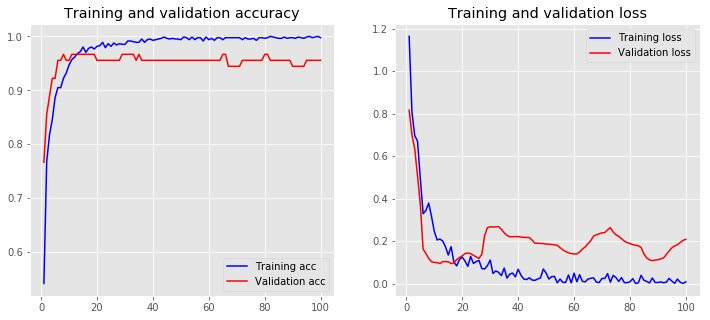

In [58]:
plot_history(history)

## RNN

### Tokenizing using Keras

In [0]:
tokenizer = Tokenizer(num_words=100)
texts = np.asarray([ x for x in critical_and_non_critical_df.Data ])
tokenizer.fit_on_texts(texts)

In [0]:
labels = np.asarray([ x for x in critical_and_non_critical_df.Critical_Finding ])

In [0]:
sequences = np.asarray(tokenizer.texts_to_sequences(texts))
sequences = pad_sequences(sequences, maxlen=100)
type(sequences)

numpy.ndarray

In [0]:
word_index = tokenizer.word_index

### Generating embedding matrix features

In [0]:
embedding_matrix = np.zeros( (len(word_index) + 1, 300) )
for word, i in word_index.items() :
  if word in word_embeddings.keys() :
    embedding_matrix[ i ] = np.array(word_embeddings[word])

In [0]:
embedding_matrix.shape

(3184, 300)

### Creating the model

In [0]:
def rnn_model():
  
  model = Sequential()
  model.add(Embedding(input_dim=len(word_index) + 1, output_dim=300, weights=[embedding_matrix], mask_zero=True, trainable=False))
  model.add(Bidirectional(LSTM(400)))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
rnn_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         955200    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 800)               2243200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               102528    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 3,301,057
Trainable params: 2,345,857
Non-trainable params: 955,200
____________________________________________________________

### Training the model

In [0]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.1, random_state=42)

estimator = KerasClassifier(build_fn=rnn_model, epochs=100, batch_size=128, verbose=1)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
early_stopping_monitor = EarlyStopping(patience=3)
estimator.fit(X_train, y_train, validation_split=0.20)

W0816 04:53:59.046143 140565653563264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 04:54:01.798280 140565653563264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0816 04:54:01.990775 140565653563264 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0

Train on 720 samples, validate on 180 samples
Epoch 1/100
720/720 [==============================] - 5s 6ms/step - loss: 0.6668 - acc: 0.5986 - val_loss: 0.5419 - val_acc: 0.7278
Epoch 2/100
720/720 [==============================] - 2s 3ms/step - loss: 0.5907 - acc: 0.6972 - val_loss: 0.4802 - val_acc: 0.7611
Epoch 3/100
720/720 [==============================] - 2s 3ms/step - loss: 0.5410 - acc: 0.7347 - val_loss: 0.4813 - val_acc: 0.7667
Epoch 4/100
720/720 [==============================] - 2s 3ms/step - loss: 0.4965 - acc: 0.7694 - val_loss: 0.4319 - val_acc: 0.8222
Epoch 5/100
720/720 [==============================] - 2s 3ms/step - loss: 0.4818 - acc: 0.7778 - val_loss: 0.4506 - val_acc: 0.7944
Epoch 6/100
720/720 [==============================] - 2s 3ms/step - loss: 0.4292 - acc: 0.7986 - val_loss: 0.3845 - val_acc: 0.7944
Epoch 7/100
720/720 [==============================] - 2s 3ms/step - loss: 0.3737 - acc: 0.8389 - val_loss: 0.3937 - val_acc: 0.8000
Epoch 8/100
720/720 [==

### Evaluating the model

In [0]:
estimator.score(X_test, y_test)

100/100 [==============================] - 0s 901us/step


0.9100000262260437

## CNN

### Creating the model

In [0]:
def cnn_model() :
  
  model = Sequential()
  model.add(Embedding(input_dim=len(word_index) + 1, output_dim=300, input_length=100, weights=[embedding_matrix], trainable=False))
  model.add(Conv1D(128, 3, padding='valid', activation='relu'))
  model.add(MaxPool1D())
  model.add(Flatten())
#   model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
cnn_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 100, 300)          955200    
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 98, 128)           115328    
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 49, 128)           0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_69 (Dense)             (None, 128)               802944    
_________________________________________________________________
dropout_43 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 129       
Total para

### Training the model

In [0]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.1, random_state=42)

estimator = KerasClassifier(build_fn=cnn_model, epochs=50, batch_size=32, verbose=1)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
early_stopping_monitor = EarlyStopping(patience=3)
estimator.fit(X_train, y_train, validation_split=0.20)

Train on 720 samples, validate on 180 samples
Epoch 1/50
720/720 [==============================] - 4s 5ms/step - loss: 0.7057 - acc: 0.6250 - val_loss: 0.5755 - val_acc: 0.7389
Epoch 2/50
720/720 [==============================] - 0s 227us/step - loss: 0.4138 - acc: 0.8264 - val_loss: 0.4070 - val_acc: 0.8444
Epoch 3/50
720/720 [==============================] - 0s 216us/step - loss: 0.2462 - acc: 0.9208 - val_loss: 0.3243 - val_acc: 0.8611
Epoch 4/50
720/720 [==============================] - 0s 207us/step - loss: 0.1347 - acc: 0.9597 - val_loss: 0.3395 - val_acc: 0.9000
Epoch 5/50
720/720 [==============================] - 0s 206us/step - loss: 0.0782 - acc: 0.9764 - val_loss: 0.2799 - val_acc: 0.8889
Epoch 6/50
720/720 [==============================] - 0s 205us/step - loss: 0.0536 - acc: 0.9847 - val_loss: 0.3334 - val_acc: 0.9000
Epoch 7/50
720/720 [==============================] - 0s 200us/step - loss: 0.0489 - acc: 0.9847 - val_loss: 0.4455 - val_acc: 0.8778
Epoch 8/50
720/720

### Evaluating the model

In [0]:
estimator.score(X_test, y_test)

100/100 [==============================] - 0s 147us/step


0.92

## BioASQ vectors

### Downloading the vectors

In [39]:
!wget http://bioasq.lip6.fr/tools/BioASQword2vec/

--2019-08-20 11:30:16--  http://bioasq.lip6.fr/tools/BioASQword2vec/
Resolving bioasq.lip6.fr (bioasq.lip6.fr)... 132.227.201.38
Connecting to bioasq.lip6.fr (bioasq.lip6.fr)|132.227.201.38|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://participants-area.bioasq.org/tools/BioASQword2vec/ [following]
--2019-08-20 11:30:17--  http://participants-area.bioasq.org/tools/BioASQword2vec/
Resolving participants-area.bioasq.org (participants-area.bioasq.org)... 143.233.226.90
Connecting to participants-area.bioasq.org (participants-area.bioasq.org)|143.233.226.90|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1341997858 (1.2G) [application/force-download]
Saving to: ‘index.html’

index.html          100%[===================>]   1.25G  7.81MB/s    in 2m 24s  

2019-08-20 11:32:41 (8.92 MB/s) - ‘index.html’ saved [1341997858/1341997858]



In [40]:
!tar -xvzf index.html

word2vecTools/toolkit.py
word2vecTools/vectors.txt
word2vecTools/
word2vecTools/README_BioASQ_word_vectors.pdf
word2vecTools/types.txt
word2vecTools/train_vectors.sh


### Loading into pandas dataframe

In [0]:
bioasq_words = []

f = open("word2vecTools/types.txt")
# f.readline()

for line in f:
  bioasq_words.append(line.split('\n')[0])
    
f.close()
bioasq_words

In [42]:
"ctdivol" in bioasq_words

True

In [0]:
bioasq_vectors = pd.read_csv( "word2vecTools/vectors.txt", sep=' ', header=None )

In [0]:
bioasq_vectors.set_index(np.array(bioasq_words), inplace=True)

In [45]:
bioasq_vectors.head()

0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29   ...       170       171       172       173       174       175       176       177       178       179       180       181       182       183       184       185       186       187       188       189       190       191       192       193       194       195       196       197       198       199
#    0.052900  0.087352  0.052608 -0.207811  0.283700  0.214404  0.141968  0.041550  0.077755  0.223129  0.126248 -0.136738 -0.126327 -0.146503 -0.062710  0.062411 -0.016453 -0.103025  0.070238  0.268668  0.133351 -0.037392  0.079420  0.166173  0.027788  0.289754  0.094303 -0.076118 -0.072871 -0.275031  ... -0.095840  0.254680  0.181076  0.086839  0.112750  0.108658  0.040082 -0.109698  0.069339 -0.023037  0.147755  0.099570 -0.192498 -0.157030  0.045981  0.278626  0.236127 -0.381710 -0.100790  0.071651 -0.135993 -0.137501  0.028501  0.062285 -0.242262 -0.003797 -0.149599 -0.029984 -0.442708 -0.016518
##  -0.043618 -0.003151 -0.040315  0.031391  0.027139  0.045431 -0.038502 -0.012109 -0.038116  0.052934 -0.010468  0.040989  0.015707 -0.043812  0.009082  0.021325  0.047516  0.057556  0.069293  0.052579  0.035994  0.002085  0.079982  0.093531  0.042617  0.007214  0.006374  0.028679  0.090514  0.005446  ...  0.005615 -0.037141  0.008183 -0.018739  0.056846  0.055950  0.085557  0.031392 -0.062549  0.004436  0.009706  0.063785 -0.069344 -0.054038 -0.038724 -0.087032  0.056288 -0.106229  0.068122 -0.012439 -0.020955  0.069405  0.055227  0.092419 -0.086495 -0.013376  0.006793 -0.023838  0.037966 -0.014283
###  0.018667 -0.025671  0.002676 -0.002042 -0.022105 -0.008198  0.013371  0.023233  0.026176 -0.057045  0.025915  0.003370 -0.012948 -0.062481 -0.004640  0.004081 -0.020933 -0.031843  0.023727 -0.002785  0.015898 -0.000148  0.006641  0.034810  0.005049  0.023362  0.010871 -0.015983  0.043357 -0.043034  ... -0.024371 -0.028238  0.058926 -0.019702 -0.031151 -0.006811  0.002727  0.012641  0.017653 -0.063437 -0.027290  0.036429 -0.013169 -0.008416 -0.042807  0.031900  0.050015 -0.071604  0.035417  0.012743  0.000056  0.008378  0.003522  0.075342 -0.065129 -0.038042  0.000035  0.007431 -0.025400 -0.016517
#-  -0.025786 -0.049484 -0.077580  0.025952  0.005298  0.057333 -0.053244 -0.036421 -0.054373  0.042096  0.012456  0.076020  0.021212  0.041388 -0.066396 -0.032906  0.091406  0.042712  0.053554  0.045337  0.060365  0.092091 -0.017426  0.093116 -0.014035 -0.073467  0.000258  0.024303 -0.010285  0.037928  ...  0.022568 -0.042787 -0.021234  0.008913 -0.038096 -0.007605  0.043121 -0.037882 -0.102261  0.009586  0.051404  0.000504 -0.015657  0.004934 -0.022754  0.006653 -0.005739 -0.042065 -0.006502  0.030191  0.053583 -0.033860 -0.018786  0.103254 -0.018260 -0.064538  0.000356 -0.002905  0.032479  0.031563
#0  -0.035765 -0.058809 -0.075940 -0.106541  0.109228 -0.044300 -0.032969  0.067577  0.114161 -0.086601 -0.192929 -0.029577 -0.012086 -0.205250 -0.107062 -0.154319 -0.097714  0.216704  0.210381  0.142559 -0.016340 -0.010894  0.038803  0.177867  0.148933  0.177291 -0.051687  0.006628  0.069168 -0.031462  ... -0.205645  0.024168  0.090042  0.026794  0.003099  0.015119  0.184132  0.003121 -0.055174 -0.109903  0.057214 -0.138748  0.072708 -0.136179 -0.024053  0.045813  0.101330 -0.070393  0.197340 -0.053123 -0.114479  0.060647 -0.072368  0.151613 -0.348300 -0.146520 -0.050565  0.021411 -0.061304  0.225124

[5 rows x 200 columns]

### Getting the word embeddings into dictionary

In [0]:
bioasq_word_embeddings = {}
non_bioasq_words = {}
for word in words_count.keys() :
    if word in bioasq_vectors.index :
        bioasq_word_embeddings[word] = bioasq_vectors.loc[ word, : ].values
    else :
        non_bioasq_words[word] = words_count[word]

In [47]:
sorted(non_bioasq_words.items(), reverse=True, key=lambda kv : (kv[1], kv[0]))

[('weismcnulty', 84),
 ('kamholtz', 50),
 ('barchie', 50),
 ('breckwoldt', 44),
 ('lowattenuation', 25),
 ('paintech', 19),
 ('fatcontaining', 14),
 ('examtechnique', 14),
 ('ageappropriate', 14),
 ('thickwalled', 13),
 ('pleuralbased', 13),
 ('veingreater', 12),
 ('indicationdx', 12),
 ('techniquenoncontrast', 11),
 ('mvctech', 10),
 ('brainstemcervical', 10),
 ('culdesac', 9),
 ('wellvisualized', 8),
 ('swanganz', 8),
 ('subacuteacute', 8),
 ('normalappearing', 8),
 ('levoscoliosis', 8),
 ('changesmyositis', 8),
 ('calvariumskull', 8),
 ('wellcircumscribed', 6),
 ('typo', 6),
 ('threephase', 6),
 ('shoddyappearing', 6),
 ('requesttech', 6),
 ('reasonpain', 6),
 ('labruzzo', 6),
 ('impressionaddendum', 6),
 ('cystweb', 6),
 ('canalthin', 6),
 ('techniquect', 5),
 ('placementtech', 5),
 ('massproducing', 5),
 ('comparisonnone', 5),
 ('willisbrain', 4),
 ('threevessel', 4),
 ('spacesposterior', 4),
 ('rupturehemorrhage', 4),
 ('reasonabdominal', 4),
 ('painexam', 4),
 ('overthewire', 4)

### Generating text vectors for each row

In [0]:
bioasq_sent_vectors = []

def vectorize_sentence(text) :
    
    sen_vec = np.zeros(200)
    for word in text.split() :
        if word in bioasq_word_embeddings.keys() :
            sen_vec += bioasq_word_embeddings[word]
    
    bioasq_sent_vectors.append(sen_vec / len(text.split()))

In [49]:
critical_and_non_critical_df.Data.apply(vectorize_sentence)
print()

### Generating embedding matrix features

In [50]:
bioasq_embedding_matrix = np.array(bioasq_sent_vectors)
bioasq_embedding_matrix.shape

(1000, 200)

### Scaling the data

In [52]:
scaler = StandardScaler()

combined_tfidf_bioasq_embed_scaled = scaler.fit_transform(bioasq_embedding_matrix)
combined_tfidf_bioasq_embed_scaled.shape

(1000, 200)

### Modeling

#### Logistic Regression

In [57]:
xtrain_embed, xvalid_embed, ytrain, yvalid = train_test_split(combined_tfidf_bioasq_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

lreg_embed = LogisticRegression()
lreg_embed.fit(xtrain_embed, ytrain) # training the model

prediction = lreg_embed.predict_proba(xvalid_embed) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.89

#### RandomForest Classifier

In [58]:
xtrain_embed, xvalid_embed, ytrain, yvalid = train_test_split(combined_tfidf_bioasq_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

rfr_embed = RandomForestClassifier()
rfr_embed.fit(xtrain_embed, ytrain) # training the model

prediction = rfr_embed.predict_proba(xvalid_embed) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.915

#### SVC

In [60]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_bioasq_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

svc_tfidf = SVC(C=1.0, kernel='linear', degree=3, probability=True)
svc_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = svc_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.8966666666666666

#### MLP Classifier

In [62]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_bioasq_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

mlp_clf_tfidf = MLPClassifier([1000, 500, 100], learning_rate_init=0.01, learning_rate='adaptive')
mlp_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = mlp_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.93

#### AdaBoost Classifier

In [63]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_bioasq_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

ada_boost_tfidf = AdaBoostClassifier(n_estimators=3000, learning_rate=0.1)
ada_boost_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = ada_boost_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.9166666666666666

#### Bagging Classifier

In [64]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_bioasq_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

bag_clf_tfidf = BaggingClassifier(n_estimators=3000, n_jobs=-1)
bag_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = bag_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.92

#### ExtraTrees Classifier

In [65]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_bioasq_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.2)

extra_trees_clf_tfidf = ExtraTreesClassifier(n_estimators=3000, n_jobs=-1, )
extra_trees_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = extra_trees_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.945

#### GradientBoosting Classifier

In [66]:
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(combined_tfidf_bioasq_embed_scaled, critical_and_non_critical_df.Critical_Finding, random_state=42, test_size=0.3)

grd_boost_clf_tfidf = GradientBoostingClassifier(n_estimators=3000)
grd_boost_clf_tfidf.fit(xtrain_tfidf, ytrain) # training the model

prediction = grd_boost_clf_tfidf.predict_proba(xvalid_tfidf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.5 # if prediction is greater than or equal to 0.5 than 1 else 0
prediction_int = prediction_int.astype(np.int)

accuracy_score(yvalid, prediction_int)

0.9233333333333333

#### Keras DenseNet Models

##### Creating the model

In [0]:
def create_baseline():
    
    model = Sequential()
#     model.add(Dense(16384, input_dim=tfidf_array.shape[1], activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(8192, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(2048, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(512, input_dim=200, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

##### Training the model

In [0]:
X_train, X_test, y_train, y_test = train_test_split(combined_tfidf_bioasq_embed_scaled, critical_and_non_critical_df.Critical_Finding, test_size=0.3, random_state=42)

estimator = KerasClassifier(build_fn=create_baseline, epochs=200, batch_size=200, verbose=1)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
early_stopping_monitor = EarlyStopping(patience=3)
estimator.fit(X_train, y_train, validation_split=0.20)

Train on 560 samples, validate on 140 samples
Epoch 1/200
560/560 [==============================] - 1s 1ms/step - loss: 1.1248 - acc: 0.4696 - val_loss: 0.6844 - val_acc: 0.5429
Epoch 2/200
560/560 [==============================] - 0s 29us/step - loss: 0.9649 - acc: 0.5268 - val_loss: 0.6819 - val_acc: 0.5500
Epoch 3/200
560/560 [==============================] - 0s 29us/step - loss: 0.9286 - acc: 0.5214 - val_loss: 0.6815 - val_acc: 0.5714
Epoch 4/200
560/560 [==============================] - 0s 28us/step - loss: 0.9222 - acc: 0.5143 - val_loss: 0.6801 - val_acc: 0.5929
Epoch 5/200
560/560 [==============================] - 0s 25us/step - loss: 0.8949 - acc: 0.5268 - val_loss: 0.6795 - val_acc: 0.6000
Epoch 6/200
560/560 [==============================] - 0s 29us/step - loss: 0.8876 - acc: 0.5036 - val_loss: 0.6798 - val_acc: 0.5929
Epoch 7/200
560/560 [==============================] - 0s 28us/step - loss: 0.9179 - acc: 0.5071 - val_loss: 0.6805 - val_acc: 0.5786
Epoch 8/200
560/5

##### Evaluating the model

In [0]:
estimator.score(X_test, y_test)

300/300 [==============================] - 0s 23us/step


0.6733333468437195

## BERT Model

### Setting up the environment

In [59]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 6.4MB/s 
     |████████████████████████████████| 655kB 48.4MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609234 sha256=1829b301082c6fb4a1ecaf1b80ff3bca20ddc32596763d85a2c44a461b1fb56f
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built regex


In [60]:
!pip install tools

     |████████████████████████████████| 92kB 13.2MB/s 
  Created wheel for tools: filename=tools-0.1.9-cp36-none-any.whl size=46759 sha256=f845fb180dd1d86f0cca9fd88f4a14928d8a58fcbc9a0e96aaf5071d32566343
  Stored in directory: /root/.cache/pip/wheels/87/67/9b/1ca7dcb0b9ebfdc23a00c85a0644abb6fb14f9159a0df8e067
  Created wheel for pytils: filename=pytils-0.3-cp36-none-any.whl size=40355 sha256=2084ef5386517857e15655ee0b7122f1c28f6703bcdba020d67e1a52b9076711
  Stored in directory: /root/.cache/pip/wheels/d6/f9/dc/4f07d8ee40d9cfca9973b3f4aeff99d0bb69900e5f3dffbf32
Successfully built tools pytils


In [0]:
# !pip install convert_examples_to_features

### Splitting train and test data

In [0]:
msk = np.random.rand(len(critical_and_non_critical_df)) < 0.8
train_df = critical_and_non_critical_df[msk]
test_df = critical_and_non_critical_df[~msk]

In [63]:
len(train_df)

799

In [64]:
len(test_df)

201

### Preparing train and test data for the model

In [65]:
train_df_bert = pd.DataFrame({
    'id':range(len(train_df)),
    'label':train_df.Critical_Finding,
    'alpha':['a']*train_df.shape[0],
    'text': train_df.Data
})

train_df_bert.head()

id  label alpha                                               text
1   0      1     a  ct abdomen and pelvis contrast indication abd ...
2   1      0     a  study ct abdomen and pelvis without contrast r...
3   2      1     a  study ct brain without contrast reason for exa...
4   3      1     a  study mri brain without contrast reason for ex...
6   4      1     a  study xray orbit reason for exam female year o...

In [66]:
dev_df_bert = pd.DataFrame({
    'id':range(len(test_df)),
    'label':test_df.Critical_Finding,
    'alpha':['a']*test_df.shape[0],
    'text': test_df.Data
})

dev_df_bert.head()

id  label alpha                                               text
0    0      1     a  study xray chest reason for exam male year old...
5    1      1     a  study ct brain without contrast reason for exa...
15   2      1     a  exam ct scan of brain without contrast indicat...
29   3      1     a  study xray soft tissue neck reason for exam fe...
33   4      0     a  study xray right tibia and fibula reason for e...

In [0]:
train_df_bert.to_csv('train.tsv', sep='\t', index=False, header=False)

In [0]:
dev_df_bert.to_csv('dev.tsv', sep='\t', index=False, header=False)

### Functions for converting examples to features

In [0]:
from __future__ import absolute_import, division, print_function

import csv
import os
import sys
import logging

logger = logging.getLogger()
csv.field_size_limit(2147483647) # Increase CSV reader's field limit incase we have long text.


class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines


class BinaryClassificationProcessor(DataProcessor):
    """Processor for binary classification dataset."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [0]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def convert_example_to_feature(example_row):
    # return example_row
    example, label_map, max_seq_length, tokenizer, output_mode = example_row

    tokens_a = tokenizer.tokenize(example.text_a)

    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    else:
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]

    tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
    segment_ids = [0] * len(tokens)

    if tokens_b:
        tokens += tokens_b + ["[SEP]"]
        segment_ids += [1] * (len(tokens_b) + 1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding = [0] * (max_seq_length - len(input_ids))
    input_ids += padding
    input_mask += padding
    segment_ids += padding

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    if output_mode == "classification":
        label_id = label_map[example.label]
    elif output_mode == "regression":
        label_id = float(example.label)
    else:
        raise KeyError(output_mode)

    return InputFeatures(input_ids=input_ids,
                         input_mask=input_mask,
                         segment_ids=segment_ids,
                         label_id=label_id)


### Importing the libraries

In [0]:
import torch
import pickle
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss

from tqdm import tqdm_notebook, trange
import os
import math
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

from multiprocessing import Pool, cpu_count
from tools import *
# import convert_examples_to_features

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Setting up the variable parameters

In [0]:
# The input data dir. Should contain the .tsv files (or other data files) for the task.
DATA_DIR = ""

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'bert-base-cased'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'yelp'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
MAX_SEQ_LENGTH = 128

TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 5
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"


In [0]:
output_mode = OUTPUT_MODE

cache_dir = CACHE_DIR

In [0]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
        REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
        os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)

In [0]:
if os.path.exists(OUTPUT_DIR) and os.listdir(OUTPUT_DIR):
        raise ValueError("Output directory ({}) already exists and is not empty.".format(OUTPUT_DIR))
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

### Initializing the processor model

In [0]:
processor = BinaryClassificationProcessor()
train_examples = processor.get_train_examples(DATA_DIR)
train_examples_len = len(train_examples)

In [0]:
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)

In [0]:
num_train_optimization_steps = math.ceil(
    train_examples_len / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS

In [0]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [0]:
label_map = {label: i for i, label in enumerate(label_list)}
train_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in train_examples]

### Convert examples to features

In [102]:

process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {train_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        train_features = list(tqdm_notebook(p.imap(convert_example_to_feature, train_examples_for_processing), total=train_examples_len))

Preparing to convert 799 examples..
Spawning 3 processes..


In [0]:

with open(DATA_DIR + "train_features.pkl", "wb") as f:
    pickle.dump(train_features, f)

In [0]:
# Load pre-trained model (weights)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)
# model = BertForSequenceClassification.from_pretrained(CACHE_DIR + 'cased_base_bert_pytorch.tar.gz', cache_dir=CACHE_DIR, num_labels=num_labels)

In [0]:
# model.to(device)

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

In [0]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP_PROPORTION,
                     t_total=num_train_optimization_steps)

### Training the model

In [0]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0

In [0]:
logger.info("***** Running training *****")
logger.info("  Num examples = %d", train_examples_len)
logger.info("  Batch size = %d", TRAIN_BATCH_SIZE)
logger.info("  Num steps = %d", num_train_optimization_steps)
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)

if OUTPUT_MODE == "classification":
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
elif OUTPUT_MODE == "regression":
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.float)

In [0]:
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=TRAIN_BATCH_SIZE)

In [111]:
model.train()
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
#         batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        logits = model(input_ids, segment_ids, input_mask, labels=None)

        if OUTPUT_MODE == "classification":
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif OUTPUT_MODE == "regression":
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), label_ids.view(-1))

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        print("\r%f" % loss, end='')
        
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

0.905716

Epoch:  20%|██        | 1/5 [10:09<40:37, 609.41s/it]

0.715862

Epoch:  40%|████      | 2/5 [20:16<30:25, 608.63s/it]

0.384901

Epoch:  60%|██████    | 3/5 [30:24<20:17, 608.64s/it]

0.143478

Epoch:  80%|████████  | 4/5 [40:32<10:08, 608.20s/it]

0.271639

Epoch: 100%|██████████| 5/5 [50:38<00:00, 607.59s/it]

### Function for evaluation report

In [0]:
def get_eval_report(task_name, labels, preds):
    mcc = accuracy_score(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "task": task_name,
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }

def compute_metrics(task_name, labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(task_name, labels, preds)

### Loading the evaluation data

In [0]:
processor = BinaryClassificationProcessor()
eval_examples = processor.get_dev_examples(DATA_DIR)
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
eval_examples_len = len(eval_examples)

In [0]:
label_map = {label: i for i, label in enumerate(label_list)}
eval_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in eval_examples]

In [115]:
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {eval_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        eval_features = list(tqdm_notebook(p.imap(convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))

Preparing to convert 201 examples..
Spawning 3 processes..


In [0]:
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)

In [0]:
if OUTPUT_MODE == "classification":
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
elif OUTPUT_MODE == "regression":
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.float)

In [0]:
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=EVAL_BATCH_SIZE)

In [119]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediat

### Evaluating the model

In [0]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, accuracy_score

In [0]:
def matthews_corrcoef_user(y_true, y_predicted):
    conf_matrix = confusion_matrix(y_true, y_predicted)
    true_pos = conf_matrix[1,1]
    false_pos = conf_matrix[1,0]
    false_neg = conf_matrix[0,1]
    n_points = conf_matrix.sum()*1.0
    pos_rate = (true_pos + false_neg) / n_points
    activity = (true_pos + false_pos) / n_points
    mcc_numerator = true_pos / n_points - pos_rate * activity
    mcc_denominator = activity * pos_rate * (1 - activity) * (1 - pos_rate)
    return mcc_numerator / np.sqrt(mcc_denominator)

In [122]:
model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids
    input_mask = input_mask
    segment_ids = segment_ids
    label_ids = label_ids

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask, labels=None)

    # create eval loss and other metric required by the task
    if OUTPUT_MODE == "classification":
        loss_fct = CrossEntropyLoss()
        tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
    elif OUTPUT_MODE == "regression":
        loss_fct = MSELoss()
        tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

    eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds = preds[0]
if OUTPUT_MODE == "classification":
    preds = np.argmax(preds, axis=1)
elif OUTPUT_MODE == "regression":
    preds = np.squeeze(preds)
result = compute_metrics(TASK_NAME, all_label_ids.numpy(), preds)

result['eval_loss'] = eval_loss

print(result)

output_eval_file = os.path.join(REPORTS_DIR, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in (result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))


{'task': 'yelp', 'mcc': 0.8955223880597015, 'tp': 84, 'tn': 96, 'fp': 15, 'fn': 6, 'eval_loss': 0.31308990504060474}
